In [1]:
from os.path import join, basename, dirname, exists
import os
from glob import glob

import numpy as np
import pandas as pd
import ast

from scipy.ndimage import imread
from matplotlib import pyplot as plt

from imgaug import augmenters as iaa
from keras.utils import Sequence

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = imread(input_path)
    
    # Convert image to the correct range
    # image = np.interp(image, [np.min(image), np.max(image)], [range_min, range_max])

    return image

In [3]:
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()

In [4]:
def get_samples_containing_label(df, label):
    
    # create list of imageIds of images that have label in their labelId list
    label_idx = []
    for row in df:
        if label in row['labelId']:
            label_idx.append(row['imageId'])
            
    # return dataframe 
    return df['imageId'].isin(label_idx)

In [5]:
def labels_one_hot(labels):
    
    onehot_label = [0.] * 228
    for label in labels:
        onehot_label[int(label) - 1] = 1.
    
    return onehot_label

In [6]:
def basic_augmentation(image):
    
    # More (simple) augmenters can be added
    aug = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Scale({"height": 299, "width": 299})
#         iaa.Affine(rotate=(-10, 10)),
#         iaa.GaussianBlur(sigma=(0.0, 0.5)),
    ])
    
    image = aug.augment_images([image])[0] / 255
    
    return image

In [7]:
class BatchGenerator(object):

    def __init__(self, input_dir, csv_path, batch_size, augmentation_fn=None):

        # Params
        self.input_dir = input_dir  # path to images
        self.csv_path = csv_path  # path to CSV
        self.batch_size = batch_size  # number of images per batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path)
        
        # Info
        self.n_samples = len(self.df)
        self.n_batches = self.n_samples // self.batch_size
        
        # Print some info
        print('BatchGenerator detected: {n_samples} image samples.'.format(n_samples=self.n_samples))

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        # Build a mini-batch

        # Randomly sample from the dataframe
        df_batch = self.df.sample(self.batch_size)
        
        # We can also sample specific labels: get_samples_containing_label()

        # Iterate over selected images 
        images = []
        labels = []
        for idx, row in df_batch.iterrows():

            try:

                # Read image path
                img_id = row['imageId']
                image_path = self.input_dir + "/" + str(img_id) + ".jpg"

                # Read data and label
                image = load_image(image_path)
                label = labels_one_hot(ast.literal_eval(row['labelId']))

                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # Append
                images.append(image)
                labels.append(label)
                
            except Exception as e:
                print('Failed reading image {idx}.jpg'.format(idx=img_id))
            
        # Assemble batch
        batch_x = np.array(images)
        batch_y = np.array(labels)

        return batch_x, batch_y

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


BatchGenerator detected: 1014544 image samples.


C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


(32, 299, 299, 3)
(32, 228)


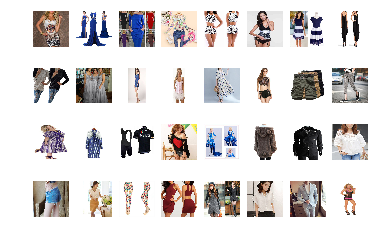

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# Testing the generator
data_dir = "D:/MLiP/data/"

training_gen = BatchGenerator(
    input_dir = join(data_dir, "train/"),
    csv_path = join(data_dir, "csv/train_labels.csv"),
    batch_size = 32,
    augmentation_fn = basic_augmentation
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    print(batch_y)
    break

In [9]:
class BatchSequence(Sequence):

    def __init__(self, input_dir, csv_path, batch_size):

        # Params
        self.input_dir = input_dir  # path to images
        self.csv_path = csv_path  # path to CSV
        self.batch_size = batch_size  # number of images per batch
        
        # Read CSV
        self.df = pd.DataFrame.from_csv(csv_path).sample(1024)
        
        # Length
        self.n_samples = len(self.df)
        self.n_batches = int(np.ceil(self.n_samples / self.batch_size))  # last mini-batch might be shorter
        
        # Print some info
        print('BatchSequence detected: {n_samples} image samples.'.format(n_samples=len(self.df)))

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def __getitem__(self, idx):
        # idx indexes batches, not samples

        # Provide batches of samples
        images = []
        labels = []
        
        # Create indexes for samples
        idx1 = idx * self.batch_size
        idx2 = np.min([idx1 + self.batch_size, self.n_samples])
        idxs = np.arange(idx1, idx2)
        
        # Iterate over samples
        for i in idxs:

            try:
                # Read image path
                row = self.df.iloc[i, :]
                img_id = row['imageId']
                image_path = self.input_dir + "/" + str(img_id) + ".jpg"
                
                # Read data and label
                image = load_image(image_path)
                label = labels_one_hot(ast.literal_eval(row['labelId']))

                resize_aug = iaa.Scale({"height": 299, "width": 299})
                image = resize_aug.augment_images([image])[0] / 255
                
                # Append
                images.append(image)
                labels.append(label)
                
            except Exception as e:
                print('Failed reading image {idx}.jpg'.format(idx=img_id))

        # Assemble batch            
        batch_x = np.array(images)
        batch_y = np.array(labels)

        return batch_x, batch_y

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


BatchSequence detected: 1024 image samples.
(32, 299, 299, 3)
(32, 228)


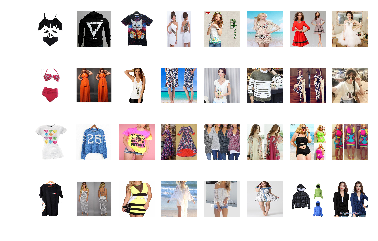

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
# Test the sequence
data_dir = "D:/MLiP/data/"

validation_seq = BatchSequence(
    input_dir = join(data_dir, 'validation/'),
    csv_path = join(data_dir, "csv/valid_labels.csv"),
    batch_size=32
)

for batch_x, batch_y in validation_seq:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x, images_per_row=8)
    print(batch_y)
    break

In [62]:
class TestSequence(Sequence):

    def __init__(self, input_dir, batch_size):

        # Params
        self.input_dir = input_dir  # path to images
        self.batch_size = batch_size  # number of images per batch
        
        # Length
        self.n_samples = 39706
        self.n_batches = int(np.ceil(self.n_samples / self.batch_size))  # last mini-batch might be shorter
        
        # Print some info
        print('TestSequence detected: {n_samples} image samples.'.format(n_samples=self.n_samples))

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches
    
    def __getitem__(self, idx):
        # idx indexes batches, not samples

        # Provide batches of samples
        images = []
        
        # Create indexes for samples
        idx1 = idx * self.batch_size
        idx2 = np.min([idx1 + self.batch_size, self.n_samples])
        idxs = np.arange(idx1, idx2)
        
        # Iterate over samples
        for i in idxs:

            try:
                img_id = i + 1
                
                # Read image path
                image_path = self.input_dir + str(img_id) + ".jpg"
                
                # Read data and label
                image = load_image(image_path)

                resize_aug = iaa.Scale({"height": 299, "width": 299})
                image = resize_aug.augment_images([image])[0] / 255
                
                # Append
                images.append(image)
                
            except Exception as e:
                print('Failed reading image {idx}.jpg'.format(idx=img_id))
                print(e)

        # Assemble batch            
        batch_x = np.array(images)

        return batch_x

In [11]:
import keras
import tensorflow as tf

# Pre-trained models imports
from keras.applications import vgg16, xception

# Preprocessing imports
from keras.applications.imagenet_utils import decode_predictions
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Layer imports
from keras.layers import Flatten, Dense
from keras import Model

In [12]:
# Get f-beta score to work in Keras
from sklearn.metrics import fbeta_score
from keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [15]:
num_classes = 228

# Setup models
base_xception_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x_xception = base_xception_model.output
x_xception = Flatten()(x_xception)
x_xception = Dense(32, activation='relu')(x_xception)
predictions_xception = Dense(num_classes, activation='sigmoid')(x_xception)

model_xception = Model(inputs=base_xception_model.input, outputs=predictions_xception)

for layer in base_xception_model.layers[:120]:
    layer.trainable = False
for layer in base_xception_model.layers[120:]:
    layer.trainable = True

model_xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=[fbeta])
logger_xception = ModelCheckpoint('xception_checkpoint.hdf5', monitor='val_fbeta', verbose=1, save_best_only=True, mode='max')

model_xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [16]:
batch_size = 16

# Define generators
training_gen = BatchGenerator(
    input_dir = join(data_dir, "train/"),
    csv_path = join(data_dir, "csv/train_labels.csv"),
    batch_size = batch_size,
    augmentation_fn = basic_augmentation
)

validation_seq = BatchSequence(
    input_dir = join(data_dir, 'validation/'),
    csv_path = join(data_dir, "csv/valid_labels.csv"),
    batch_size = batch_size
)

# init_op = tf.initialize_all_variables()

# sess = tf.Session()
# sess.run(init_op)

# Train the model
history = model_xception.fit_generator(
    generator = training_gen, # generator
    steps_per_epoch = 64,
    epochs = 10,
    validation_data = validation_seq, # sequence
    callbacks = [logger_xception],
)

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


BatchGenerator detected: 1014544 image samples.
BatchSequence detected: 1024 image samples.


C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10


C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


63/64 [============================>.] - ETA: 0s - loss: 0.5457 - fbeta: 0.1411
Epoch 00001: val_fbeta improved from -inf to 0.15468, saving model to xception_checkpoint.hdf5
64/64 [==============================] - 77s 1s/step - loss: 0.5410 - fbeta: 0.1411 - val_loss: 0.2700 - val_fbeta: 0.1547
Epoch 2/10
63/64 [============================>.] - ETA: 0s - loss: 0.1234 - fbeta: 0.1651
Epoch 00002: val_fbeta did not improve
64/64 [==============================] - 67s 1s/step - loss: 0.1228 - fbeta: 0.1649 - val_loss: 0.1281 - val_fbeta: 0.1262
Epoch 3/10
63/64 [============================>.] - ETA: 0s - loss: 0.0908 - fbeta: 0.1578
Epoch 00003: val_fbeta did not improve
64/64 [==============================] - 64s 1s/step - loss: 0.0908 - fbeta: 0.1586 - val_loss: 0.1224 - val_fbeta: 0.1242
Epoch 4/10
63/64 [============================>.] - ETA: 0s - loss: 0.0874 - fbeta: 0.1603
Epoch 00004: val_fbeta did not improve
64/64 [==============================] - 64s 996ms/step - loss: 0.

In [63]:
# Load the best weights
model_xception.load_weights('xception_checkpoint.hdf5')

test_seq = TestSequence(
    input_dir = join(data_dir, 'test/'),
    batch_size = batch_size,
)

predictions = model_xception.predict_generator(
    generator = test_seq,
    verbose = 1
)

TestSequence detected: 39706 image samples.


C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


2482/2482 [==============================] - 1161s 468ms/step


In [64]:
print(len(predictions))
print(predictions[0])

39706
[2.67191813e-03 3.06378324e-02 2.09015765e-04 2.21268218e-02
 4.01440114e-02 7.64206231e-01 1.06711246e-01 2.41920084e-01
 1.77336987e-02 3.42659473e-01 1.22550495e-01 6.35478199e-02
 5.25877392e-03 3.26707244e-01 1.77531724e-03 1.78222314e-01
 1.59870490e-01 7.45324671e-01 6.39397725e-02 7.17982531e-01
 1.73162669e-02 9.06700094e-04 1.25431949e-02 1.21575408e-01
 9.17091407e-03 1.09430186e-01 1.49636254e-01 1.21419951e-01
 1.71407703e-02 3.75485539e-01 8.73071477e-02 5.11648655e-02
 2.10789107e-02 6.38167188e-03 3.65354978e-02 8.77944171e-01
 6.83469355e-01 7.95213692e-03 1.72377542e-01 2.67247140e-01
 4.71920781e-02 2.63307872e-03 4.58099274e-03 1.87107939e-02
 1.16328278e-03 1.40464464e-02 8.29403996e-02 8.77715705e-04
 5.68764210e-02 3.15370023e-01 7.95468837e-02 7.22797289e-02
 2.67697647e-02 3.06213871e-02 9.16155055e-03 5.40285464e-03
 2.99837977e-01 2.06118062e-01 3.24039087e-02 5.31046232e-03
 2.36648917e-02 3.15132678e-01 1.22126080e-01 5.24278641e-01
 1.95551738e-01 8.

In [69]:
import csv

predictions[predictions >= 0.5] = 1
predictions[predictions < 0.5] = 0

with open('submission.csv', 'w') as file:
    file.write('image_id,label_id\n')
    for i, row in enumerate(predictions):
        rowstr = str(i+1) + ','
        for i, prediction in enumerate(row):
            if prediction == 1:
                rowstr += str(i+1) + ' '
        file.write(rowstr[:-1] + '\n')